# Initial Set-Up:

## Set up google colab

In [1]:
from google.colab import drive 
# mount google drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries for the project



In [2]:
import pandas as pd
# Importing library
from scipy.stats import f_oneway, kruskal
!pip install scikit_posthocs
from scikit_posthocs import posthoc_dunn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle
import io
import torch
from torch import nn
import re
from random import sample

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# [Data Processing](https://www.geeksforgeeks.org/ml-understanding-data-processing/)


## Collection

In this step, I am collecting the data from the indicated source, and inspecting it

In [3]:
path, filename = "drive/MyDrive/Colab_Notebooks/Zendesk - challenge/", "Clothing_Shoes_and_Jewelry_5.csv"
df_coll = pd.read_csv(path+filename)

In [4]:
df_coll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   asin            278677 non-null  object
 1   helpful         278677 non-null  object
 2   overall         278677 non-null  int64 
 3   reviewText      278653 non-null  object
 4   reviewTime      278677 non-null  object
 5   reviewerID      278677 non-null  object
 6   reviewerName    278208 non-null  object
 7   summary         278676 non-null  object
 8   unixReviewTime  278677 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [5]:
df_coll.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600


## Preparation

In this step, I am going to rearange the data in a solid dafaframe that can be used further in the process

In [6]:
df_prep = df_coll.copy()

for the sake of time in preperation the data, I will only use part of the dataset to prepare. Comment this later

In [7]:
#df_prep = df_prep.sample(200)

Spliting the **helpful** information into two columns

In [8]:
yes_list, total_list = [], []
for helpful in df_prep['helpful']:
    yes, total = tuple(map(int, helpful[1:-1].split(', ')))
    yes_list.append(yes)
    total_list.append(total)

# modifying the dataset
df_prep['helpful_yes'], df_prep['helpful_total'] = yes_list, total_list
df_prep.drop('helpful', axis='columns', inplace=True)

# delete temporary variables
del yes_list, total_list, helpful

Formating the **reviewTime** column as day/month/year

In [9]:
df_prep['reviewTime'] = pd.to_datetime(df_prep['reviewTime'], format='%m %d, %Y').dt.strftime('%d/%B/%Y')

Changing the types of each columns

In [10]:
df_prep = df_prep.astype(
    dtype = {
        'asin'           : 'string',
        'overall'        : 'int64',
        'reviewText'     : 'string',
        'reviewTime'     : 'datetime64',
        'reviewerID'     : 'string',
        'reviewerName'   : 'string',
        'summary'        : 'string',
        'unixReviewTime' : 'int64',
        'helpful_yes'    : 'int64',
        'helpful_total'  : 'int64'
    }
)

In [11]:
df_prep.describe()

,overall,unixReviewTime,helpful_yes,helpful_total
count,278677.000000,2.786770e+05,278677.000000,278677.00000
mean,4.245133,1.374197e+09,1.145936,1.34460
std,1.103747,2.904510e+07,6.579834,7.05004
min,1.000000,1.048896e+09,0.000000,0.00000
25%,4.000000,1.362787e+09,0.000000,0.00000
50%,5.000000,1.382141e+09,0.000000,0.00000
75%,5.000000,1.393200e+09,1.000000,1.00000
max,5.000000,1.406074e+09,1200.000000,1267.00000


In [12]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   asin            278677 non-null  string        
 1   overall         278677 non-null  int64         
 2   reviewText      278653 non-null  string        
 3   reviewTime      278677 non-null  datetime64[ns]
 4   reviewerID      278677 non-null  string        
 5   reviewerName    278208 non-null  string        
 6   summary         278676 non-null  string        
 7   unixReviewTime  278677 non-null  int64         
 8   helpful_yes     278677 non-null  int64         
 9   helpful_total   278677 non-null  int64         
dtypes: datetime64[ns](1), int64(4), string(5)
memory usage: 21.3 MB


In [13]:
df_prep.to_csv(path+'data_prepared.csv')

## Input

This process is responsible to rearange the data so we can correlated them feed into an algorithm further in the code. Examples of stages in the step are:

1.   [Answering the questions of the *Analysis* section of the handout assignment](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=i-WZAOxwtsFj&line=1&uniqifier=1);
2.   [Creating Labels for the classification algorithm](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=Vtb930iBH0A1&line=1&uniqifier=1).


In [14]:
try: df_in = df_prep.copy()
except: df_in = pd.read_csv(path+'data_prepared.csv')

### 1. Answering the questions of the *Analysis* section of the handout assignment

#### **Question:** "Is there a correlation between the rating of the product and the helpfulness of the review?"

In [15]:
df_in['helpful_yes_rate'] = (df_in['helpful_yes']/df_in['helpful_total']).fillna(0)
# let's assume that the values are swaped when the data is wrong... e.g. 30730
for idx in df_in[df_in['helpful_yes_rate']>1].index:
    df_in.loc[idx, 'helpful_yes_rate'] = 1/df_in.loc[idx, 'helpful_yes_rate']

In [16]:
df_in['overall'].value_counts()

5    163240
4     58357
3     30425
2     15463
1     11192
Name: overall, dtype: int64

considering the correlations only for comments that actually have feedback

In [17]:
df_in[df_in['helpful_total']>0].groupby('overall')[['helpful_yes_rate','helpful_total']].describe()

helpful_yes_rate                                                    \
                   count      mean       std  min       25%       50%  75%   
overall                                                                      
1                 5995.0  0.631549  0.384493  0.0  0.333333  0.750000  1.0   
2                 6420.0  0.671804  0.388214  0.0  0.500000  0.857143  1.0   
3                10670.0  0.710662  0.381658  0.0  0.500000  1.000000  1.0   
4                17300.0  0.796399  0.338300  0.0  0.666667  1.000000  1.0   
5                46636.0  0.823752  0.318385  0.0  0.750000  1.000000  1.0   

             helpful_total                                                   
         max         count      mean        std  min  25%  50%  75%     max  
overall                                                                      
1        1.0        5995.0  4.879233  11.230816  1.0  1.0  2.0  5.0   336.0  
2        1.0        6420.0  4.041589   8.761629  1.0  1.0  2.0  4.0   230.0  
3        1.0       10670.0  4.003655   9.722356  1.0  1.0  2.0  4.0   440.0  
4        1.0       17300.0  4.052312  10.508323  1.0  1.0  2.0  4.0   402.0  
5        1.0       46636.0  4.431920  13.555016  1.0  1.0  2.0  4.0  1267.0

In [18]:
def correlation_kruskal_dunn(df:pd.DataFrame, metrics:list):
    if isinstance(metrics, str): metrics = [metrics, ]
    for metric in metrics:
        k=kruskal(
            df[df['overall']==1][metric],
            df[df['overall']==2][metric],
            df[df['overall']==3][metric],
            df[df['overall']==4][metric],
            df[df['overall']==5][metric]
        )
        print(f'p value of kruskal is {k.pvalue:.3e}')

        d = posthoc_dunn(a=df,val_col=metric, group_col='overall')
        print(d)

To analysis correlation between categorical and continuous variables we can use statistical analysis. Kruskal-Wallis H test is used instead of one-way ANOVA because the assumption of being normally distributed is not met. [Source.](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [19]:
correlation_kruskal_dunn(df_in[df_in['helpful_total']>0], ['helpful_yes_rate', 'helpful_yes', 'helpful_total'])

p value of kruskal is 0.000e+00
               1              2              3              4              5
1   1.000000e+00   4.871823e-16   5.923915e-64  1.027121e-268   0.000000e+00
2   4.871823e-16   1.000000e+00   1.003862e-15  2.144853e-148  5.705584e-258
3   5.923915e-64   1.003862e-15   1.000000e+00   2.096013e-93  1.401961e-207
4  1.027121e-268  2.144853e-148   2.096013e-93   1.000000e+00   2.904200e-18
5   0.000000e+00  5.705584e-258  1.401961e-207   2.904200e-18   1.000000e+00
p value of kruskal is 6.894e-77
              1             2             3             4             5
1  1.000000e+00  5.445562e-05  5.549399e-04  5.678102e-04  5.722517e-14
2  5.445562e-05  1.000000e+00  2.889131e-01  1.992542e-17  1.006029e-39
3  5.549399e-04  2.889131e-01  1.000000e+00  2.695180e-18  1.457577e-49
4  5.678102e-04  1.992542e-17  2.695180e-18  1.000000e+00  7.511583e-09
5  5.722517e-14  1.006029e-39  1.457577e-49  7.511583e-09  1.000000e+00
p value of kruskal is 1.479e-80
          

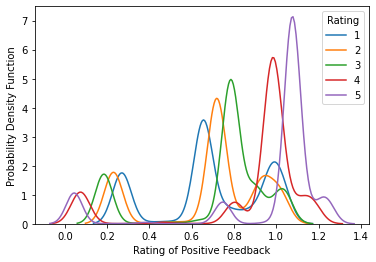

In [20]:
fig, ax = plt.subplots()
for rating in set(df_in['overall']):

    # plot normal distribution with mean 0 and standard deviation 1
    x = df_in.loc[(df_in['helpful_total']>0) & (df_in['overall']==rating)]['helpful_yes_rate']
    sns.kdeplot(norm.pdf(x, x.mean(), x.std()), ax=ax, label=str(rating))

plt.legend(title="Rating",loc='best')
plt.xlabel('Rating of Positive Feedback')
plt.ylabel('Probability Density Function')
plt.show()

**Answer:** Yes, there is a correlation between the rating of the product and its helpfulness. However, the relation is not crystal clear, since we have to manipulate the data at least two times. To prove the correlation between both variables I had to calculate the rate of positive feedback $\frac{feedcak[yes]}{feedback[total]}$, and could only consider reviews with at least one rating. Additionally, the higher the rating of the product, the higher the number of feedback, therefore the data is not balanced. So, it is used a non-parametric statistical test between a categorical and continuous variable: Kruskal and a *posthoc* Dunn's test. We confirm statistical independence (p<0.05) between all conditions, proving the correlation between both variables.

#### **Question:** "Who are the most helpful reviewers?"

In [21]:
# it takes ~21 min to run.
'''
df_in['helpful_yes_per_product'] = pd.NA
for p in set(df_in['asin']):    # for every product
    # computes the division of positive feedback review on a review and the number of reviews of a single product. Because there might be few helful reviews of the review but if noboby else has nothing to say. That review might be worthy.
    n_reviews = df_in[df_in['asin']==p].shape[0]
    df_in.loc[df_in['asin']==p, ['helpful_yes_per_product']] = df_in[df_in['asin']==p]['helpful_yes']/n_reviews
'''
# just load the pickle
with open(path+'helpful_yes_per_product.pickle','rb') as f:
    df_in['helpful_yes_per_product']=pickle.load(f) 

In [22]:
df_in['help_weight'] = df_in['helpful_yes_per_product']*df_in['helpful_yes_rate']

residual = 1e-5 # add residuals to prevent dividing by 0, fortunately, it will not affect the ranking of the top influencers
ranking=df_in.groupby('reviewerID')['help_weight'].mean()/(df_in.groupby('reviewerID')['help_weight'].mean().max()+residual)+\
                        df_in.groupby('reviewerID')['help_weight'].max()/(df_in.groupby('reviewerID')['help_weight'].max().max()+residual)+\
                        df_in.groupby('reviewerID')['help_weight'].sum()/(df_in.groupby('reviewerID')['help_weight'].sum().max()+residual)

In [23]:
def most_helpful(n:int):
    print(f'Top {n} of the Most Helpful Reviewers:')
    pos=['st','nd','rd','th','th','th','th','th','th','th']
    for i, reviewer in enumerate(ranking.sort_values(ascending=False).head(n).index):
        print(f"{i+1}{pos[(i)%len(pos)]}: {df_in[df_in['reviewerID']==reviewer]['reviewerName'].head(1).values[0]}")

    del pos, i, reviewer

**Answer:** To obtain the **n** most helpful reviewers run the following line, adjusting the n value.

```
most_helpful(n)
```

The computation of this metric is divided into two steps.


1.   [Relevance of the review on the product;](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=Da7KHJ272htR&line=3&uniqifier=1)

Since the dataset is not balanced between products of different ratings, an absolute metric would overrate higher ratings and would be biased toward reviewers who reviewed more these products. The applied formula collects the impact of the review based on all reviews made. Therefore weighs how a review stands out over all reviews of a specific product. So, for a specific product $p$, the formula is:

\begin{equation*}
\frac{\#(feedback[yes])_p}{\#(reviews)_p}
\end{equation*}
with $\#(x)_p$ being the total number of $x$ related to the product $p$.

At this point, I have the impact of each review (column: **helpful_yes_per_product**). With these results, we can call the **helpful_reviews** when for reviews in which this metric is equal to or higher than one. Likewise, it is called **unhelpful_reviews** for reviews for which this value is less than 1 but higher than 0. These reviews are considered labeled and the is unlabeled (result equal to 0).

2.   [Balance between all reviews of each reviewer.](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=37dnw0unSZhc&line=1&uniqifier=1)

At this stage, I evaluated the earlier computation to consider also the negative feedback. Therefore I multiplied the previous value by its correspondent *rate of positive feedback*. This step was not performed earlier because it does not look into the context of the review on all reviews. The result is the column **help_weight**.

Finally, for each reviewer, I used three different metrics to balance their influence on the platform, on the **help_weight** values.

1.   **mean** - The mean of all values gives the consistency of the reviewer;
2.   **max**  - The max value gives the top peek of their most helpful review;
3.   **sum**  - Their effort of all comments ( as the expression goes _step by step ..._).

Finally, the top 10 is composed by:

In [24]:
most_helpful(10)

Top 10 of the Most Helpful Reviewers:
1st: MariaSmiles
2nd: Dirk J. Willard "Dirk Willard"
3rd: Andrew Conley "Andrew"
4th: Sandra Hender "Master Writer and Poet"
5th: C
6th: Joanna Daneman
7th: Tallgirl77
8th: Gadget Girl
9th: Michael G. Lustig
10th: Matthew G. Sherwin


#### **Question:** "Have reviews been getting more or less helpful over time?"

In [25]:
# it takes ~20 min
'''
products{}
df_in['products_time']=pd.NA
for p in set(df_in['asin']):    # for every product
    # lets compute the correlation of time and the rate
    product = df_in.loc[df_in['asin']==p]
    # products[p] = product['unixReviewTime'].corr(product['helpful_yes_rate'])
    df_in.loc[df_in['asin']==p, ['products_time',]] = product['unixReviewTime'].corr(product['helpful_yes_rate'])
'''
with open(path+"products_time.pickle", 'rb') as f:
     df_in['products_time'] = pickle.load(f)

# df_in['products_time'] = df_in['products_time'].fillna(0).astype(float)

count    75573.000000
mean        -0.372486
std          0.330978
min         -0.999628
25%         -0.611262
50%         -0.399682
75%         -0.184966
max          0.997221
Name: products_time, dtype: float64

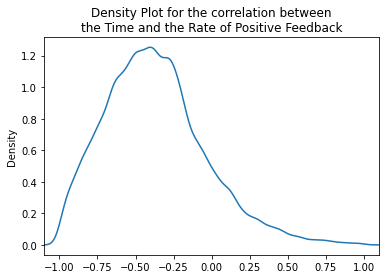

In [26]:
df_in[df_in['helpful_yes_per_product']>0]['products_time'].dropna().plot.density()
plt.title('Density Plot for the correlation between\nthe Time and the Rate of Positive Feedback')
plt.xlim(-1.1, 1.1)
df_in[df_in['helpful_yes_per_product']>0]['products_time'].dropna().astype(float).describe()

count    5004.000000
mean       -0.532319
std         0.307359
min        -0.998908
25%        -0.760078
50%        -0.583459
75%        -0.366478
max         0.997221
Name: products_time, dtype: float64

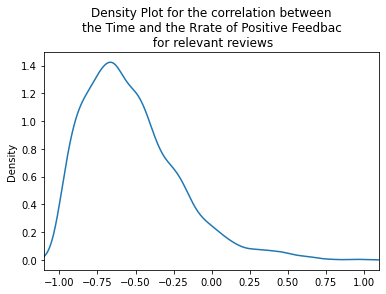

In [27]:
df_in[df_in['helpful_yes_per_product']>1]['products_time'].dropna().plot.density()
plt.title('Density Plot for the correlation between\nthe Time and the Rrate of Positive Feedbac\n for relevant reviews')
plt.xlim(-1.1, 1.1)
df_in[df_in['helpful_yes_per_product']>1]['products_time'].dropna().astype(float).describe()

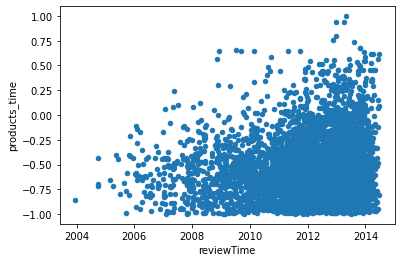

In [28]:
df_in[df_in['helpful_yes_per_product']>1].dropna().plot.scatter('reviewTime', 'products_time')

**Answer:** Reviews have been getting less helpful over time. To support this answer, I ran a correlation between the time of a posted review and its positive rate of positive feedback for each product. However, this metric is not the most accurate, since treating the rate of positive feedback is constant every time (contrarily to the question "...over time...").

Nevertheless, the results show that the correlation between the time of the post and the review's rate of positive feedback is a medium negative correlation. To show graphically our results, I plotted 3 figures showing:


1.   [The density of the correlation between the time and the rate of positive feedback, for comments with at least one feedback.](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=r5IsllOgsG0R&line=2&uniqifier=1)
2.   [The density of the correlation between the time and the rate of positive feedback, for comments with a higher number of positive feedback than comments on all products.](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=_sSnSX424fx6&line=1&uniqifier=1)

> Comparing the two previous analyses, when using only the relevant most relevant comments, the mean and the standard deviation decreased, showing more data gathering around a higher negative correlation.

3.   [The scatter plot shows that more and more reviews on products have been made over time, although they have not gotten better over time. The y-axis reflects the correlation between the time and the helpfulness of the review.](https://colab.research.google.com/drive/1qfZ9R4eHEpvHCBqrUpxQzyShawtuQtiD#scrollTo=UHgs5MtF5gO9&line=1&uniqifier=1)

### 2. Creating Labels for the classification algorithm

Sentence to be answered: "after someone writes a review, _will it be considered helpful by other users?_"

#### Preparing inputs for a Random Forest Attempt

In [29]:
!pip install textstat
from textstat import dale_chall_readability_score, flesch_reading_ease
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
df_rf = df_in[['overall',]]
df_rf['target'] = list(map(lambda x: 1 if x>=1 else 0 if x>0 else -1, df_in['helpful_yes_per_product']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
with open(path+'polarity.json') as f:
    polarity_template = json.load(f)

In [32]:
def exract_information_from_text(samples: list):
    '''extracts information for each string in a list'''
    sentences = list(map(lambda s: re.split('\.{1,}|[?!]+', s), samples))    # split by sentences
    n_sentences = list(map(lambda s: len(s) if s[-1]!='' else len(s)-1, sentences))    # remove the las [''] when happens. this is caused by the punctiation

    n_words = list(map(lambda s: len(re.sub('\.{1,}|[?!]+', '', s).split(' ')), samples))   # gets the number of words in each sentence
    n_words_per_n_sentences = [n_words[i]/n_sentences[i] for i in range(0, len(n_words))]   # computes the word/sentence ratio

    n_chars = list(map(lambda s: len(re.sub('\.{1,}|[?!]+', '', s).replace(' ','')), samples))
    n_chars_per_n_words = [n_chars[i]/n_words[i] for i in range(0, len(n_words))]

    dale_chall = [dale_chall_readability_score(s) for s in samples]

    flesch_re = [flesch_reading_ease(s) for s in samples]

    # the polarity is the rate of positive words - negative words (divided by the size of the review) in the review
    intersection = lambda x: (len(list(set(x) & set(polarity_template['positive'])))-len(list(set(x) & set(polarity_template['negative']))))/len(set(x))
    polarity = [intersection(" ".join(s).lower().split(' ')) for s in sentences]

    return n_sentences, n_words_per_n_sentences, n_chars_per_n_words, dale_chall, flesch_re, polarity

In [33]:
# ~5 min to run... 
# df_rf['summary_n_sentences'], df_rf['summary_n_words_per_n_sentences'], df_rf['summary_n_chars_per_n_words'], df_rf['summary_dale_chall'], df_rf['summary_flesch_re'], df_rf['summary_polarity'] = exract_information_from_text(df_in['summary'].astype(str).values)
# df_rf['reviewText_n_sentences'], df_rf['reviewText_n_words_per_n_sentences'], df_rf['reviewText_n_chars_per_n_words'], df_rf['reviewText_dale_chall'], df_rf['reviewText_flesch_re'], df_rf['reviewText_polarity'] = exract_information_from_text(df_in['reviewText'].astype(str).values)
df_rf = pd.read_csv(path+'df_rf.csv')


In [34]:
print(f"Size of the positive targets in the dataset: {df_rf[df_rf['target']==1].shape[0]}")

Size of the positive targets in the dataset: 6015


In [35]:
# Balacing the final dataset, by concatenating two dataframes of different classes but the same size
df_rf_balanced = pd.concat([df_rf[df_rf['target']==1], df_rf[df_rf['target']==0].sample(df_rf[df_rf['target']==1].shape[0])])   # [targets=1, samples over targets=0 (number of times of the len of the targets1 class 1)]


## Processing

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)   # ignore all future warnings
!pip install transformers emoji==0.6.0
from transformers import AutoTokenizer, AutoModelForSequenceClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
class RandomForest(RandomForestClassifier):
    def __init__(self, n_estimators=1250, min_samples_split=2, min_samples_leaf=2, max_depth=5):
        super().__init__()
        self.clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

    def evaluation(self, X_test, y_test, display_roc=True):
        # Quantitative metrics
        y_pred = self.clf.predict(X_test)
        print(f'Accuracy : {accuracy_score(y_test, y_pred):.3f}')
        print(f'Recall   : {recall_score(y_test, y_pred):.3f}')
        print(f'Precision: {precision_score(y_test, y_pred):.3f}')
        print(f'F1 score : {f1_score(y_test, y_pred):.3f}')

        print('Normalized Consufion matrix')
        print(confusion_matrix(y_test,y_pred,normalize='true'))

        # Display ROC and AUC
        if display_roc: plot_roc_curve(self.clf, X_test, y_test)

    def features_importance(self, features):
        importances = self.clf.feature_importances_   # Mean Decrease in Impurity (MDI)
        std = np.std([tree.feature_importances_ for tree in self.clf.estimators_], axis=0)

        forest_importances = pd.Series(importances, index=list(features))

        fig, ax = plt.subplots(figsize=(12,9)) # 4:3
        forest_importances.plot.barh(xerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")


    def random_search(self,X_train, y_train, X_test, y_test):
        # Use the random grid to search for best hyperparameters

        # Number of trees in random forest
        n_estimators = [1000, 1250, 1500]
        # Maximum number of levels in tree
        max_depth = [5, 10, 15]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 4]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [2, 4]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
        }

        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)   # GridSearchCV
        # Fit the random search model
        rf_random.fit(X_train, y_train)
        print("Accuracy:",accuracy_score(y_test, rf_random.predict(X_test)))
        print(rf_random.best_params_)

## Output

### Vanilla Random Forest

In [38]:
# Transforms to np.array the labels and the target values
targets = np.array(df_rf_balanced['target'])
features = df_rf_balanced.drop(['target','summary_n_sentences'], axis = 1)
labels = np.array(features)

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(labels, targets, test_size=.20) # 80% training, 20% data

print(f'Training Labels Shape:      {X_train.shape}')
print(f'Training Targets Shape      {y_train.shape}')
print(f'Testing Labels Shape:       {X_test.shape}')
print(f'Testing Targets Shape:      {y_test.shape}')

Training Labels Shape:      (9624, 12)
Training Targets Shape      (9624,)
Testing Labels Shape:       (2406, 12)
Testing Targets Shape:      (2406,)


In [40]:
forest = RandomForest() 

In [41]:
# forest.random_search(X_train, y_train, X_test, y_test)  # it takes a few minutes...
print("{'n_estimators':1250, :min_samples_split':2, 'min_samples_leaf':2, 'max_depth':5}")

{'n_estimators':1250, :min_samples_split':2, 'min_samples_leaf':2, 'max_depth':5}


In [42]:
forest.clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=1250)

In [43]:
forest.evaluation(X_train, y_train, display_roc=False)

Accuracy : 0.667
Recall   : 0.647
Precision: 0.677
F1 score : 0.662
Normalized Consufion matrix
[[0.68764374 0.31235626]
 [0.35281967 0.64718033]]


Accuracy : 0.670
Recall   : 0.666
Precision: 0.660
F1 score : 0.663
Normalized Consufion matrix
[[0.67288961 0.32711039]
 [0.33390119 0.66609881]]


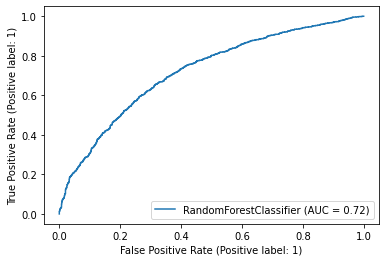

In [44]:
forest.evaluation(X_test, y_test)

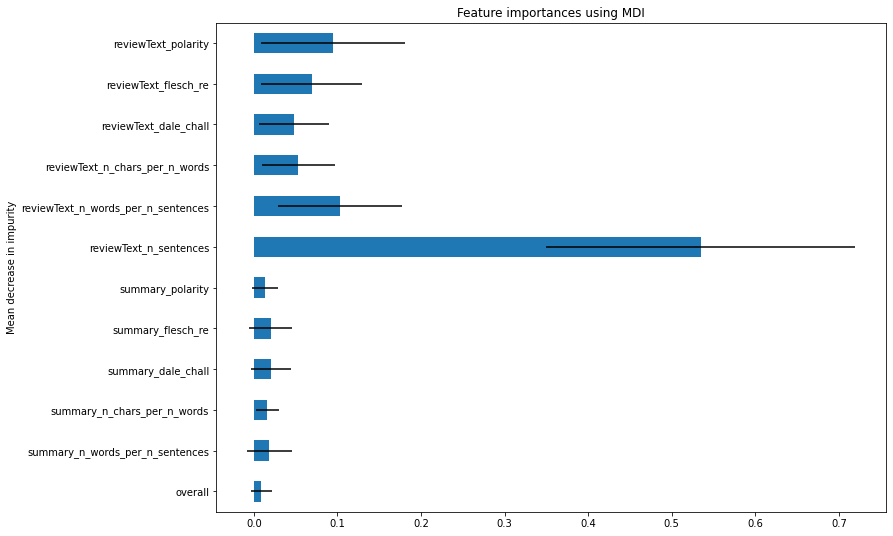

In [45]:
forest.features_importance(features.columns)

### Baseline values

In [46]:
forest_base = RandomForestClassifier()
forest_base.fit(X_train, y_train)
y_pred = forest_base.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, y_pred):.3f}')
print(f'Recall   : {recall_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'F1 score : {f1_score(y_test, y_pred):.3f}')

Accuracy : 0.650
Recall   : 0.641
Precision: 0.641
F1 score : 0.641


### Adding BERT

In [47]:
model_name='finiteautomata/bertweet-base-sentiment-analysis' # 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Let's use BERT to get the Sentiment Analysis of our inputs

In [48]:
# it takes 1:45 h ro run, CAREFUL.
# df_rf_balanced['summary_BERT_sentiment'] = df_in.iloc[df_rf_balanced['target'].index.to_list()]['summary'].apply(lambda x: int(torch.argmax(model( tokenizer.encode(x[:512], return_tensors='pt', truncation='only_first') ).logits)))
# df_rf_balanced['reviewText_BERT_sentiment'] = df_in.iloc[df_rf_balanced['target'].index.to_list()]['reviewText'].fillna('').apply(lambda x: int(torch.argmax(model( tokenizer.encode(x[:512], return_tensors='pt', truncation='only_first') ).logits)))
df_rf_balanced = pd.read_csv(path+'df_rf_balanced_2_BERT.csv')

In [49]:
# Transforms to np.array the labels and the target values
targets_BERT = np.array(df_rf_balanced['target'])
features_BERT = df_rf_balanced.drop(['target','summary_n_sentences'], axis = 1)
labels_BERT = np.array(features_BERT)
# Split the data into training and testing sets
X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT = train_test_split(labels_BERT, targets_BERT, test_size=.20) # 80% training, 20% data

print(f'Training Labels Shape:      {X_train_BERT.shape}')
print(f'Training Targets Shape      {y_train_BERT.shape}')
print(f'Testing Labels Shape:       {X_test_BERT.shape}')
print(f'Testing Targets Shape:      {y_test_BERT.shape}')

Training Labels Shape:      (9624, 16)
Training Targets Shape      (9624,)
Testing Labels Shape:       (2406, 16)
Testing Targets Shape:      (2406,)


Accuracy : 0.663
Recall   : 0.600
Precision: 0.677
F1 score : 0.636
Normalized Consufion matrix
[[0.72281276 0.27718724]
 [0.39983094 0.60016906]]


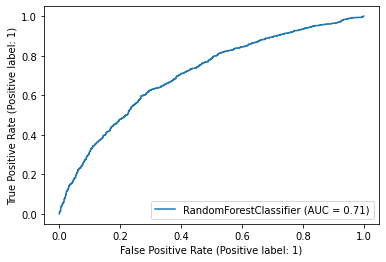

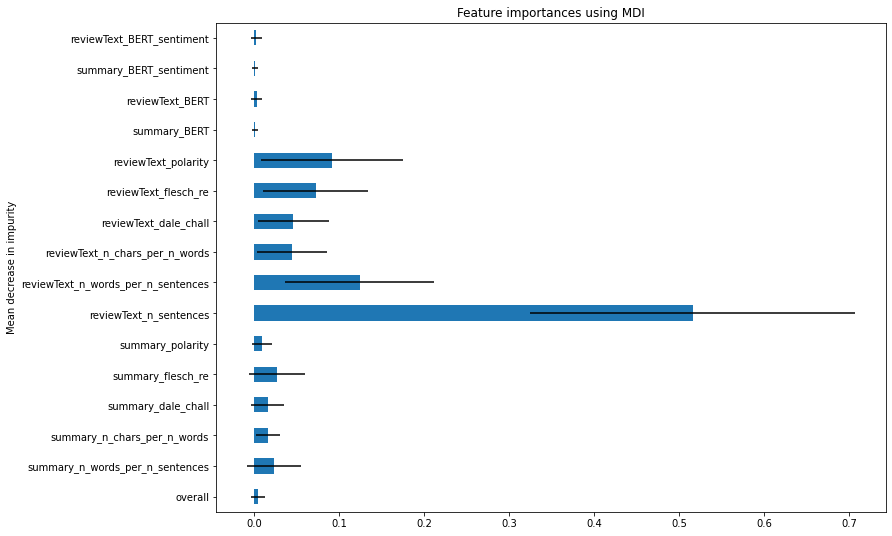

In [50]:
forest_BERT = RandomForest()
forest_BERT.clf.fit(X_train_BERT, y_train_BERT)
forest_BERT.evaluation(X_test_BERT, y_test_BERT)
forest_BERT.features_importance(features_BERT.columns)

### Prediction of the Unlabeled Data

In [51]:
final_pred = forest.clf.predict(df_rf.loc[df_rf['target']==-1,].drop(['target','summary_n_sentences'], axis=1,))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [52]:
pd.DataFrame(list(final_pred)).value_counts()

0    168573
1     34320
dtype: int64

## Storage